### Imports

In [2]:
import pandas as pd
import os
from pathlib import Path
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Input Raw File and Decoder File

In [41]:
files = [
    "QCHWK",
    # "QCHWQ",
    # "QCHXD",
    # "QCHXG",
    # "QCHXL",
    # "QCHXM",
    # "QCHXV",
    # "QCHXW",
    # "QCHXX",
    # "QCHY1",
    # "QCHY2",
    # "QCHY6",
    # "QCHY7",
    # "QCHY8",
    # "QCHYG",
    # "QCHYH",
    # "QCHYK",
    # "QCHYR",
    # "QCHYS",
    # "QCHYT",
    # "QCHZ1",
    # "QCHZ5",
    # "QCHZ6",
    # "QCHZ8",
    # "QCHZH",
]  # List of wafer codes

summaryfile_name = "qchwq"

decoder_file = "QC WAFER_LAYOUT 24Dec.csv"
# Define the current script's directory
current_dir = Path(os.getcwd())
# Move to the root directory
root_dir = current_dir.parents[0]  # Adjust the number based on your folder structure
# Define the path to the required subfolder
file_paths = []
for wafer_code in files:
    for file in os.listdir(root_dir / "LIV_Raw_Files"):
        if wafer_code in file and "COD250" in file:
            file_paths.append(root_dir / "LIV_Raw_Files" / file)
decoder_file_path = root_dir / "decoders" / decoder_file
cod_summary_file_path = root_dir / "cod_summaries"
print(file_paths)

[WindowsPath('c:/Users/762093/OneDrive - Seagate Technology/Documents/LIV/liv-cod-algorithm/LIV_Raw_Files/LIV_53_QCHWK_DNS-LIVTKCOD_LCRVCOD250-DNS_RAW20250219183049.csv')]


# Transform Data to Desired Raw Sweep Format

- selects required columns
- transposes
- stacks data in tall format
- adds in device coords from decoder file

In [42]:
# Transforming Raw File Code


warnings.filterwarnings("ignore")


raw_sweeps_list = []


for file_path in file_paths:

    # Read the CSV file, skipping the first 19 rows
    df = pd.read_csv(file_path, skiprows=19)

    # Read the CSV file again to extract the second row

    header_df = pd.read_csv(file_path, nrows=2)

    # Extract the wafer id from the second row

    wafer_id = header_df.iloc[1, 1]

    # Print the wafer id for verification

    print(f"Wafer ID: {wafer_id}")

    # Get the directory of the file

    folder = file_path.parent

    print(f"Directory: {folder}")

    # Get column names
    col_names = df.columns

    # Find columns containing "Vf" or "PD"

    selected_cols = [col for col in col_names if "Vf" in col or "PD" in col]

    # Subset the data frame with selected columns

    df_subset = df[selected_cols]

    # Find and delete columns containing "Vf@" or "PD@"

    cols_to_delete = [col for col in df_subset.columns if "Vf@" in col or "PD@" in col]

    df_subset.drop(columns=cols_to_delete, inplace=True)

    # Transpose the data frame

    df_transposed = df_subset.transpose()

    # Reset index to make the transposed columns into rows

    df_transposed.reset_index(inplace=True)

    # Add a new row at the top with the desired titles

    new_columns = ["Label"] + list(range(1, len(df_transposed.columns)))
    df_transposed.columns = new_columns

    df_transposed.loc[-1] = new_columns  # Add the new row at the top
    df_transposed.index = df_transposed.index + 1  # Shift the index

    df_transposed = df_transposed.sort_index()  # Sort by index to place the new row at the top

    # Display the first 10 rows of df_transposed

    df_transposed.head(10)
    # df_subset.head(10)

    # Split transposed table into Vf and PD data tables
    df_vf = df_transposed[df_transposed["Label"].str.contains("Vf")]
    df_pd = df_transposed[df_transposed["Label"].str.contains("PD")]

    # df_vf.head(10)
    # df_pd.head(10)

    # Drop the 'Label' column
    df_vf.drop(columns=["Label"], inplace=True)
    df_pd.drop(columns=["Label"], inplace=True)

    # learn data dimensions

    n_meas = df_vf.shape[0]
    print(f"Number of Current Measurements per Device: {n_meas}")

    n_devices = df_vf.shape[1]
    print(f"Number of Devices: {n_devices}")

    # Concatenate all Voltage columns into one

    df_concat_vf = pd.concat([df_vf[col] for col in df_vf.columns], ignore_index=True).to_frame(name="Vf")

    # Create TOUCHDOWN column
    df_concat_vf["TOUCHDOWN"] = [i // n_meas + 1 for i in range(n_meas * n_devices)]

    # Concatenate all PD columns into one
    df_concat_pd = pd.concat([df_pd[col] for col in df_pd.columns], ignore_index=True).to_frame(name="PD")

    # Cartesian join of Vf and PD data tables
    df_raw_sweeps = pd.concat([df_concat_vf, df_concat_pd], axis=1)

    # df_raw_sweeps.head(270)

    # Add device coordinates from original RAW file

    if "TOUCHDOWN" in df.columns and "STX_WAFER_X_UM" in df.columns and "STX_WAFER_Y_UM" in df.columns:
        df_raw_sweeps = df_raw_sweeps.merge(df[["TOUCHDOWN", "STX_WAFER_X_UM", "STX_WAFER_Y_UM"]], on="TOUCHDOWN", how="left")
    else:

        print("Required columns for merging device coordinates are missing in the original RAW file.")

    if decoder_file_path.exists():
        df_decoder = pd.read_csv(decoder_file_path)

        # Update with decoder to get TE_LABEL etc.
        if "YMIN" in df_decoder.columns and "XMIN" in df_decoder.columns:

            df_raw_sweeps = df_raw_sweeps.merge(
                df_decoder[["YMIN", "XMIN", "TE_LABEL", "TYPE"]],
                left_on=["STX_WAFER_Y_UM", "STX_WAFER_X_UM"],
                right_on=["YMIN", "XMIN"],
                how="left",
            ).drop(columns=["YMIN", "XMIN"])
        else:
            print("Required columns for merging decoder data are missing in the decoder file.")
    else:
        print(f"Decoder file not found at {decoder_file_path}")

    # Rename the columns

    df_raw_sweeps.rename(columns={"STX_WAFER_X_UM": "X_UM", "STX_WAFER_Y_UM": "Y_UM"}, inplace=True)

    # Add current column as a repeating sequence of length n_meas

    df_raw_sweeps["LDI_mA"] = [i % n_meas + 1 for i in range(len(df_raw_sweeps))]

    # Add a column for WAFER_ID with the wafer_id value repeated for every row
    df_raw_sweeps.insert(0, "WAFER_ID", wafer_id)

    raw_sweeps_list.append(df_raw_sweeps)


# Display the first 10 rows of df_raw_sweeps
# raw_sweeps_list[0].head(379500)

Wafer ID: QCHWK
Directory: c:\Users\762093\OneDrive - Seagate Technology\Documents\LIV\liv-cod-algorithm\LIV_Raw_Files
Number of Current Measurements per Device: 250
Number of Devices: 1288


# Delta Method COD Algorithm

 - calculates delta differentials
 - checks if a differential is below a certain threshold
 - this threshold is weighted by the mean PD

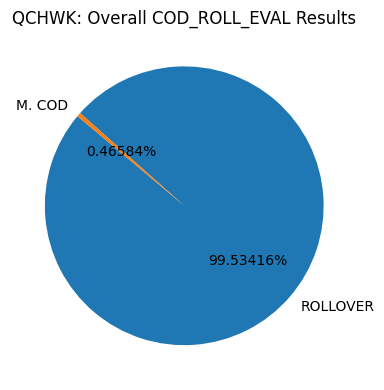

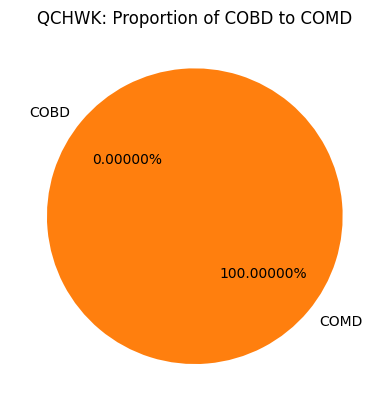

In [50]:
DELTA_ALGORITHM_MIN_DELTA = 1
DELTA_ALGORITHM_MAX_PD = 1

summary_tables = []
cod_percentages = []

for df_raw_sweeps in raw_sweeps_list:
    # Calculate dV/dI
    df_raw_sweeps["dV/dI"] = (df_raw_sweeps["Vf"].diff()) / (df_raw_sweeps["LDI_mA"].diff())
    # Calculate dP/dI
    df_raw_sweeps["DP/DI"] = (df_raw_sweeps["PD"].diff()) / (df_raw_sweeps["LDI_mA"].diff())
    # Calculate MAX_PD
    df_raw_sweeps["MAX_PD"] = df_raw_sweeps.groupby(["TE_LABEL"])["PD"].transform("max")
    # Calculate MEAN_PD
    df_raw_sweeps["MEAN_PD"] = df_raw_sweeps.groupby(["TE_LABEL"])["PD"].transform("mean")
    # Calculate DELTA
    df_raw_sweeps["DELTA"] = df_raw_sweeps["MEAN_PD"] - df_raw_sweeps["DP/DI"].abs()
    # Calculate MIN_DELTA
    df_raw_sweeps["MIN_DELTA"] = df_raw_sweeps.groupby(["TE_LABEL"])["DELTA"].transform("min")

    # MAIN CHECK OF IF COD'd
    # Calculate COD_ROLL_EVAL
    conditions = [
        (df_raw_sweeps["MIN_DELTA"] > DELTA_ALGORITHM_MIN_DELTA),
        (df_raw_sweeps["MAX_PD"] < DELTA_ALGORITHM_MAX_PD),
    ]
    choices = ["ROLLOVER", "NO LASER"]
    df_raw_sweeps["COD_ROLL_EVAL"] = np.select(conditions, choices, default="COD")

    # # Calculate the average of dV/dI for the current row, 2 rows ahead, and 2 rows behind
    # df_raw_sweeps["AVG_DV_DI"] = df_raw_sweeps["dV/dI"].rolling(window=5, center=True).mean()

    # Calculate POT_FAILMODE using the dV/dI
    df_raw_sweeps["POT_FAILMODE"] = df_raw_sweeps["COD_ROLL_EVAL"]
    df_raw_sweeps.loc[(df_raw_sweeps["COD_ROLL_EVAL"] == "COD") & (df_raw_sweeps["dV/dI"] > 0), "POT_FAILMODE"] = "COMD"
    df_raw_sweeps.loc[(df_raw_sweeps["COD_ROLL_EVAL"] == "COD") & (df_raw_sweeps["dV/dI"] < 0), "POT_FAILMODE"] = "COBD"

    # Calculate DEV_CURR_AT_ROLLOVER
    df_raw_sweeps["DEV_CURR_AT_ROLLOVER"] = np.where(
        (df_raw_sweeps["PD"] == df_raw_sweeps["MAX_PD"]) & (df_raw_sweeps["COD_ROLL_EVAL"] == "ROLLOVER"),
        df_raw_sweeps["LDI_mA"],
        np.nan,
    )
    # Calculate DEV_CURR_AT_SPD
    df_raw_sweeps["DEV_CURR_AT_SPD"] = np.where(
        (df_raw_sweeps["PD"] == df_raw_sweeps["MAX_PD"]) & (df_raw_sweeps["COD_ROLL_EVAL"] == "COD"),
        df_raw_sweeps["LDI_mA"],
        np.nan,
    )
    # Calculate CURRENT_AT_ROLLOVER
    df_raw_sweeps["CURRENT_AT_ROLLOVER"] = df_raw_sweeps.groupby(["TE_LABEL"])["DEV_CURR_AT_ROLLOVER"].transform("median")
    # Calculate CURRENT_AT_SPD
    df_raw_sweeps["CURRENT_AT_SPD"] = df_raw_sweeps.groupby(["TE_LABEL"])["DEV_CURR_AT_SPD"].transform("median")
    # Annotate the dV/dI value at the point of COD fail
    df_raw_sweeps["DV_DI_AT_COD"] = np.where(
        (df_raw_sweeps["COD_ROLL_EVAL"] == "COD"),
        df_raw_sweeps["dV/dI"],
        np.nan,
    )
    # Flag lasers with multiple COD flags as 'M. COD' and single COD as 'COD'
    cod_counts = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == "COD"].groupby("TE_LABEL").size()
    multiple_cod_labels = cod_counts[cod_counts > 1].index.tolist()

    def flag_cod(te_label, cod_roll_eval):
        if cod_roll_eval == "COD" and te_label in multiple_cod_labels:
            return "M. COD"
        return cod_roll_eval

    df_raw_sweeps["COD_ROLL_EVAL"] = df_raw_sweeps.apply(lambda row: flag_cod(row["TE_LABEL"], row["COD_ROLL_EVAL"]), axis=1)

    # Create COD Summary table with POT_FAILMODE
    cod_summary = (
        df_raw_sweeps.groupby("TE_LABEL")
        .agg(
            {
                "WAFER_ID": "first",
                "TYPE": "first",
                "X_UM": "first",
                "Y_UM": "first",
                "COD_ROLL_EVAL": "first",
                "POT_FAILMODE": "first",
                "MAX_PD": "first",
                "MEAN_PD": "first",
                "MIN_DELTA": "first",
                "CURRENT_AT_ROLLOVER": "first",
                "CURRENT_AT_SPD": "first",
                "DV_DI_AT_COD": "last",  # Include the annotated dV/dI value
            }
        )
        .reset_index()
    )
    summary_tables.append(cod_summary)

    # Calculate COD percentage for the wafer code
    cod_count = cod_summary[cod_summary["COD_ROLL_EVAL"] == "COD"].shape[0]
    total_count = cod_summary.shape[0]

    if total_count > 0:
        cod_percentage = (cod_count / total_count) * 100
        wafer_code = cod_summary["WAFER_ID"].iloc[0]
        cod_percentages.append({"Wafer Code": wafer_code, "COD Percentage": cod_percentage})

# Save COD percentages to a CSV file
cod_percentages_df = pd.DataFrame(cod_percentages)
cod_percentages_df.to_csv(cod_summary_file_path / f"{summaryfile_name}_cod_percentages.csv", index=False)


# Plotting COD Summary for Each Wafer Code
for cod_summary in summary_tables:
    wafer_code = cod_summary["WAFER_ID"].iloc[0]

    # Plot overall COD_ROLL_EVAL results
    overall_cod_roll_eval_counts = cod_summary["COD_ROLL_EVAL"].value_counts()

    plt.figure(figsize=(4, 4))
    plt.pie(
        overall_cod_roll_eval_counts,
        labels=overall_cod_roll_eval_counts.index,
        autopct="%1.5f%%",
        startangle=140,
    )
    plt.tight_layout()
    plt.title(f"{wafer_code}: Overall COD_ROLL_EVAL Results")
    plt.show()

    # # Plot separate pie charts for each TYPE
    # types = cod_summary["TYPE"].unique()

    # for t in types:
    #     type_data = cod_summary[cod_summary["TYPE"] == t]
    #     type_cod_roll_eval_counts = type_data["COD_ROLL_EVAL"].value_counts()

    #     # Calculate proportions
    #     total_count = type_cod_roll_eval_counts.sum()
    #     cod_count = type_cod_roll_eval_counts.get("COD", 0)
    #     nolaser_count = type_cod_roll_eval_counts.get("NO LASER", 0)
    #     rollover_count = type_cod_roll_eval_counts.get("ROLLOVER", 0)

    #     non_cod_count = total_count - cod_count

    #     cod_proportion = (cod_count / total_count) * 100
    #     non_cod_proportion = (non_cod_count / total_count) * 100

    #     # Print proportions
    #     print(f"Type: {t}")
    #     print(f"COD: {cod_proportion:.2f}%")
    #     print(f"Non-COD: {non_cod_proportion:.2f}%\n")

    #     # Plot pie chart
    #     plt.figure(figsize=(4, 4))

    #     plt.pie(
    #         type_cod_roll_eval_counts,
    #         labels=type_cod_roll_eval_counts.index,
    #         autopct="%1.5f%%",
    #         startangle=140,
    #     )
    #     plt.tight_layout()
    #     plt.title(f"{wafer_code}: COD_ROLL_EVAL Results for TYPE: {t}")
    #     plt.show()

    # # Proportion of Laser Types
    # type_counts = cod_summary["TYPE"].value_counts()
    # print("\nProportion of Types:")
    # print(type_counts / type_counts.sum() * 100)
    # # Plot a pie chart indicating the proportion of types
    # plt.figure(figsize=(4, 4))
    # plt.pie(type_counts, labels=type_counts.index, autopct="%1.5f%%", startangle=140)
    # plt.title("Proportion of Types")
    # plt.show()

    # Calculate the proportion of COBD to COMD
    failmode_counts = cod_summary["POT_FAILMODE"].value_counts()
    cobd_comd_counts = failmode_counts.reindex(["COBD", "COMD"], fill_value=0)
    # print("\nProportion of CODs:")
    # print(cobd_comd_counts / cobd_comd_counts.sum() * 100)
    # Plot the proportion of COBD to COMD
    plt.figure()
    plt.pie(cobd_comd_counts, labels=cobd_comd_counts.index, autopct="%1.5f%%", startangle=140)
    plt.title(f"{wafer_code}: Proportion of COBD to COMD")
    plt.show()

## COD rate against type comparison

QCHWK: - Number of SILC devices: 322

QCHWK: - Number of BL LASER devices: 966

QCHWK: 
       TYPE  COD_prop  MSE
0      SILC       0.0  0.0
1  BL LASER       0.0  0.0



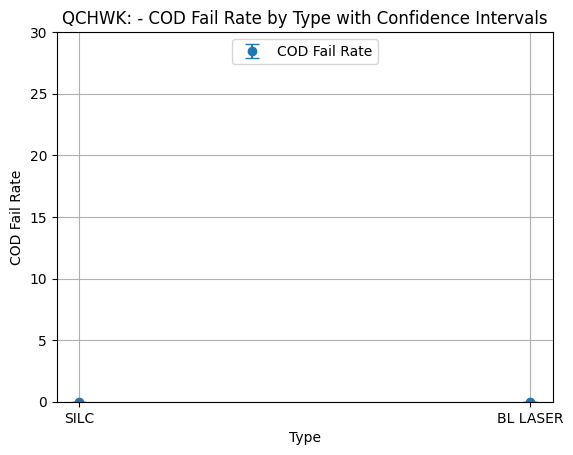

In [51]:
# Calculate the MSE error on the percentages using the proportion rule
def calculate_mse(p, n):
    return np.sqrt((p * (1 - p)) / n)


# Iterate over each raw sweeps dataframe in the list and calculate the MSE error on the percentages
for cod_summary in summary_tables:
    wafer_code = cod_summary["WAFER_ID"].iloc[0]
    mse_data = []
    for t in cod_summary["TYPE"].unique():
        type_data = cod_summary[cod_summary["TYPE"] == t]
        type_cod_roll_eval_counts = type_data["COD_ROLL_EVAL"].value_counts()

        # Calculate proportions
        total_count = type_cod_roll_eval_counts.sum()
        print(f"{wafer_code}: - Number of {t} devices: {total_count}\n")
        cod_count = type_cod_roll_eval_counts.get("COD", 0)
        cod_proportion = cod_count / total_count

        # Calculate MSE
        mse = calculate_mse(cod_proportion, total_count)

        mse_data.append((t, cod_proportion, mse))

    # Convert to DataFrame for easier plotting
    mse_df = pd.DataFrame(mse_data, columns=["TYPE", "COD_prop", "MSE"])
    mse_df["COD_prop"] = mse_df["COD_prop"] * 100
    mse_df["MSE"] = mse_df["MSE"] * 100

    print(f"{wafer_code}: \n{mse_df}\n")

    # Plot COD fail rate against type with confidence intervals annotated
    plt.figure()
    plt.errorbar(
        mse_df["TYPE"],
        mse_df["COD_prop"],
        yerr=mse_df["MSE"],
        fmt="o",
        capsize=5,
        label="COD Fail Rate",
    )
    plt.xlabel("Type")
    plt.ylabel("COD Fail Rate")
    plt.ylim([0, 30])
    plt.title(f"{wafer_code}: - COD Fail Rate by Type with Confidence Intervals")
    plt.legend(loc="upper center")
    plt.grid(True)
    plt.show()

# Raw Sweep Plotting

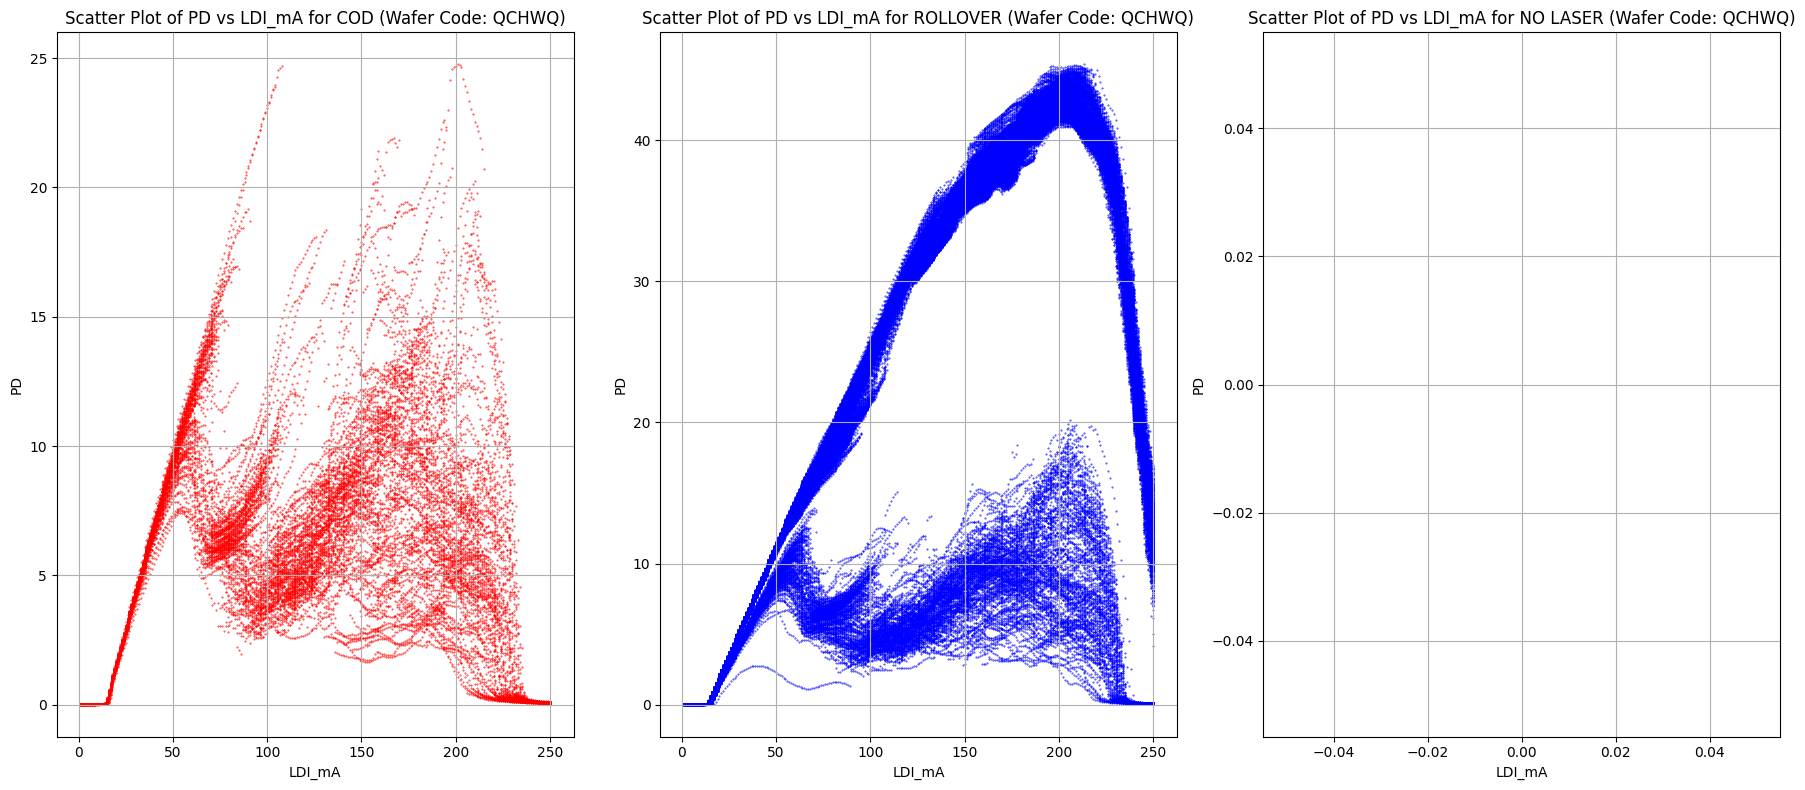

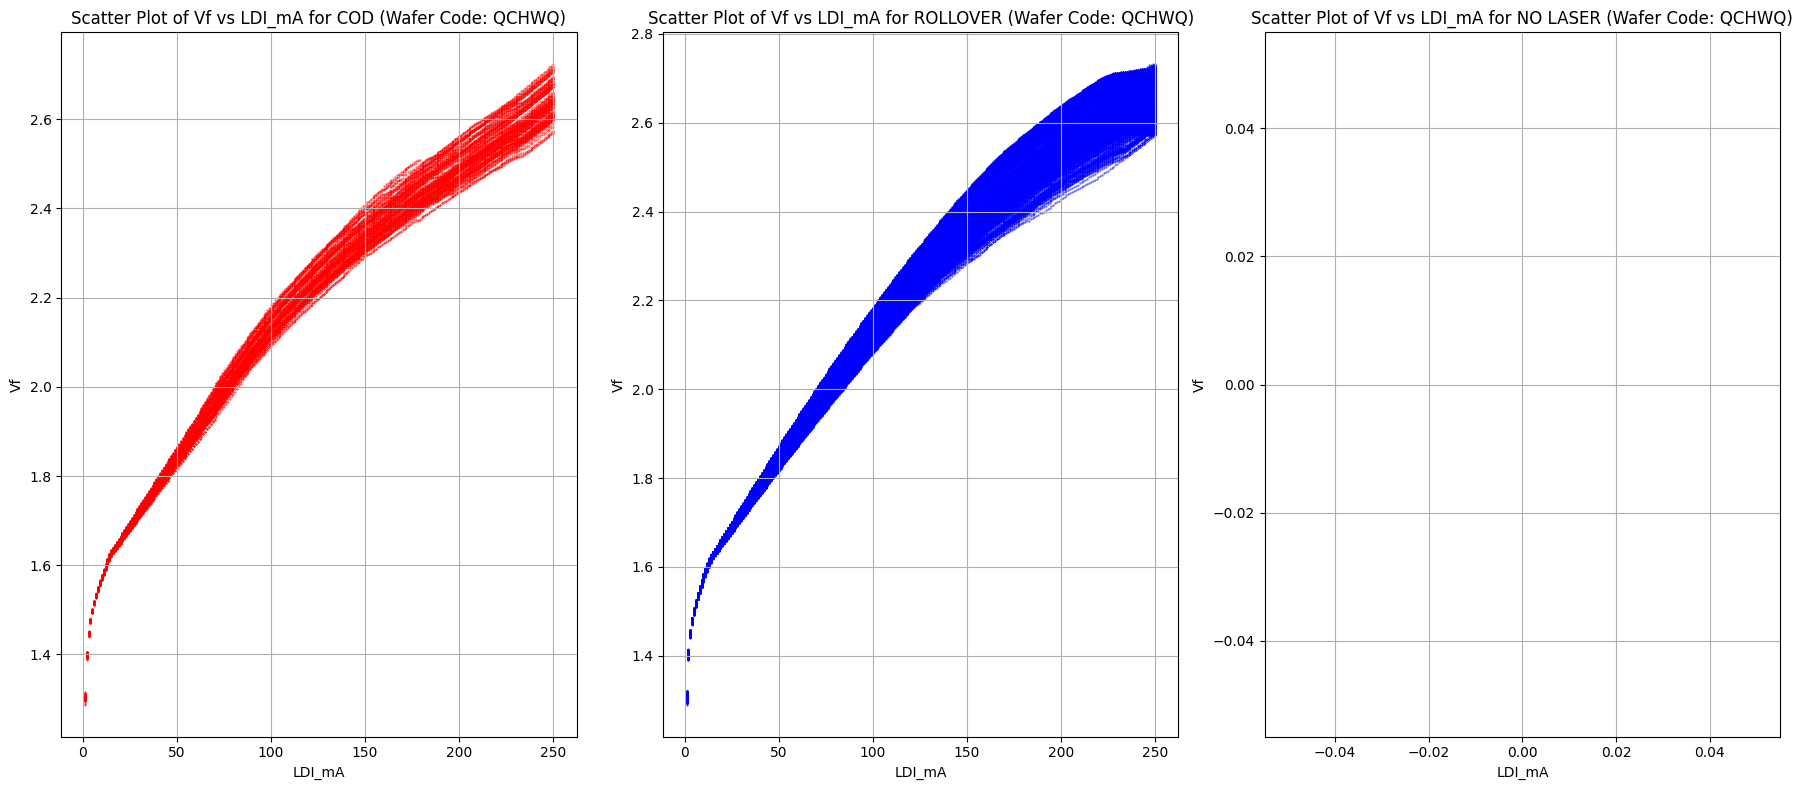

In [19]:
# Iterate over all raw sweeps dataframes and create subplots for each of the 3 types (COD, ROLLOVER, and NO LASER)
for df_raw_sweeps in raw_sweeps_list:
    wafer_code = df_raw_sweeps["WAFER_ID"].iloc[0]

    # Scatter plot of PD against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, axs = plt.subplots(1, 3, figsize=(18, 8))
    cod_roll_eval_types = ["COD", "ROLLOVER", "NO LASER"]
    colors = ["red", "blue", "orange"]

    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["PD"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of PD vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("PD")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Scatter plot of Vf against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, axs = plt.subplots(1, 3, figsize=(18, 8))

    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["Vf"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of Vf vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("Vf")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

Touchdown numbers with COD evaluation for Wafer Code QCHWK: [ 436  829  830 1286 1287 1288]


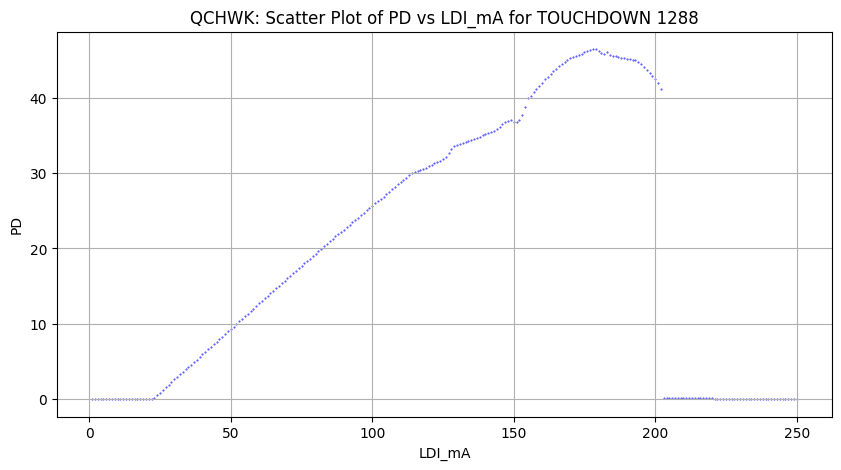

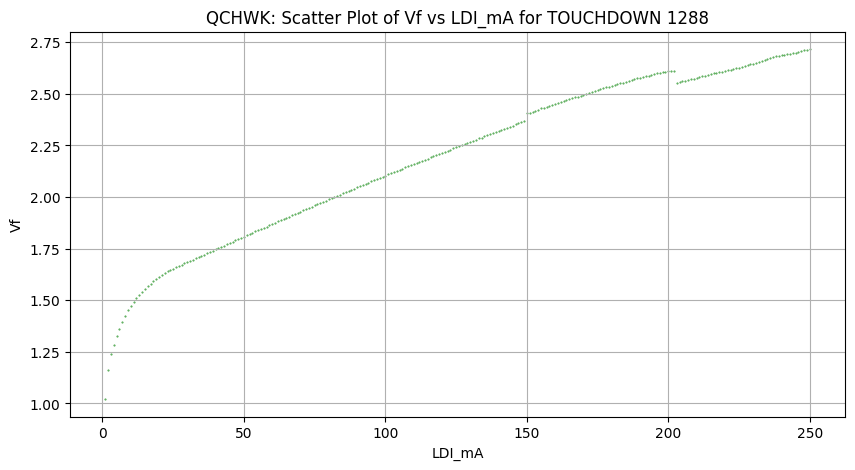

In [49]:
# Function to plot PD/LDI and Vf/LDI for a specific laser and wafer
def plot_specific_touchdown(df_raw_sweeps, wafer_code, touchdown):
    specific_data = df_raw_sweeps[(df_raw_sweeps["WAFER_ID"] == wafer_code) & (df_raw_sweeps["TOUCHDOWN"] == touchdown)]

    if specific_data.empty:
        print(f"No data found for Wafer Code: {wafer_code} and TOUCHDOWN: {touchdown}")
        return

    # Plot PD/LDI
    plt.figure(figsize=(10, 5))
    plt.scatter(specific_data["LDI_mA"], specific_data["PD"], alpha=0.8, s=0.2, color="blue")
    plt.title(f"{wafer_code}: Scatter Plot of PD vs LDI_mA for TOUCHDOWN {touchdown}")
    plt.xlabel("LDI_mA")
    plt.ylabel("PD")
    plt.grid(True)
    plt.show()

    # Plot Vf/LDI
    plt.figure(figsize=(10, 5))
    plt.scatter(specific_data["LDI_mA"], specific_data["Vf"], alpha=0.8, s=0.2, color="green")
    plt.title(f"{wafer_code}: Scatter Plot of Vf vs LDI_mA for TOUCHDOWN {touchdown}")
    plt.xlabel("LDI_mA")
    plt.ylabel("Vf")
    plt.grid(True)
    plt.show()


# Define the specific wafer code and TOUCHDOWN number
wafer_code = "QCHWK"
touchdown = 1288  # Replace with the desired TOUCHDOWN number

# Find the correct dataframe where the wafer code matches the input
df_raw_sweeps = None
for df in raw_sweeps_list:
    if df["WAFER_ID"].iloc[0] == wafer_code:
        df_raw_sweeps = df
        break

if df_raw_sweeps is not None:
    # Search for touchdown numbers where COD_ROLL_EVAL == COD
    cod_touchdowns = df_raw_sweeps[(df_raw_sweeps["COD_ROLL_EVAL"] == "COD") | (df_raw_sweeps["COD_ROLL_EVAL"] == "M. COD")]["TOUCHDOWN"].unique()
    print(f"Touchdown numbers with COD evaluation for Wafer Code {wafer_code}: {cod_touchdowns}")

    # Plot for the specified touchdown number
    plot_specific_touchdown(df_raw_sweeps, wafer_code, touchdown)
else:
    print(f"No data found for Wafer Code: {wafer_code}")